In [2]:
#@title Imports  { form-width: "30%" }

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import itertools
import time

from graph_nets import graphs
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos import models
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy import spatial
import tensorflow as tf
#import random

import math
import threading
import time



In [3]:
""" 全局变量定义　"""
# alpha_agents,数目设定
ALPHA_AGENTS_NUM = 50
# alpha_agnets探测距离r(meter)
DETECTION_RANGE = 500
# flocking 间距d(meter)，小于等于agents的探测范围r
FLOCKING_DISTANCE = 300
# 圆周率PI
PI = 3.1415
# 单位时间alpha_agents单步迭代，位移动作距离STEP_DRIFT(meter)
STEP_DRIFT = 0.5

# 生成全局地图(10000m * 10000m)
WIDTH = 10000  # meter
LENGTH = 10000  # meter

In [4]:
"""得到初始状态矩阵: S_0 """
mapSquare = [WIDTH,LENGTH]  
print(mapSquare)
# 设定alpha_agents属性：初始位置，探测范围，初始速度，

# 设定alpha_agents属性：
# @ alphaAgentsNum: 集群数目
# @ alphaAgentsNum: 集群位置矩阵
# @ alphaAgentsInitialSpeed: 集群初始速度矩阵
# @ alphaAgentsDetectionRange: alpha_agents探测范围(meter)       
# 生成指定数目alpha_agents的随机位置和初始随机速度
# @ alphaAgentsInitialPos [50,5]矩阵,[[pos_x,pos_y,0,0,0],....]
# @ alphaAgentsInitialSpeed [50,5]矩阵,[[v_x, v_y],0,0,0]设定范围在[0,5](m/s)
posArray = np.zeros((50,5))
speedArray = np.zeros((50,5))
SEED = 1
np.random.seed(SEED)
tf.set_random_seed(SEED)

for i in range(ALPHA_AGENTS_NUM):
    posArray[i][0] = np.random.randint(0,mapSquare[1])  # pos_x
    posArray[i][1] = np.random.randint(0,mapSquare[1])  # pos_y
    posArray[i][2] = i  # 设定alpha_agents的全局唯一编号AGENT_NUM
for i in range(ALPHA_AGENTS_NUM):
    speedArray[i][0] = 1 # v_x([0,5]m/s)
    speedArray[i][1] = 1 # v_y([0,5]m/s)
    speedArray[i][2] = i
    
# 初始化状态矩阵：S_0    
alphaAgentsInitialPos = posArray
# 初始化速度矩阵：v_0
alphaAgentsInitialSpeed = speedArray


[10000, 10000]


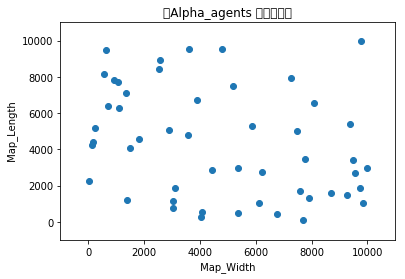

In [5]:
"""
得到初始位置，初始速度
"""
# check part.
List1 = []
List2 = []
for i in range(50):
    tmp1 = alphaAgentsInitialPos[i][0]
    tmp2 = alphaAgentsInitialPos[i][1]
    List1.append(tmp1)
    List2.append(tmp2)
x = List1
y = List2
# check part.
plt.scatter(x,y)
plt.title("　Alpha_agents 初始位置　")
plt.xlabel(" Map_Width ")
plt.ylabel(" Map_Length ")
plt.axis([-1000,11000,-1000,11000])
plt.show()

In [6]:
"""通过graph_nets.lib 进行图神经网络初始化
# 初始化主要包含几个存储函数，几个计算函数，以及相应的更新函数
# 存储函数主要是存储：Flocking状态序列S_t=[...,S_i_t,...]，回报序列R_t=[...,R_i_t,...],
    策略序列PI_t==[...,PI_i_t,...],动作序列A_t = =[...,A_i_t,...]
# 计算函数主要是计算：根据策略计算动作PI_t->S_t；根据动作计算新的状态A_t->S_t+1;根据经验计算新策略
    PI_t->PI_t+1;根据新状态计算回报值S_t+1->R_t+1
"""
# T 为一次训练迭代的总次数
T = 1000000
# 存储函数,存储这里用
# 每一条边，每一个节点的每一个属性都根据时间序列做一个List
def exps_saved_Fun(boolStamp, timeStamp, dataArray, fileName):
    t = timeStamp
    boolTmp = boolStamp
    # 需要保存的数据
    savedData = dataArray
    # 需要将数据保存到的位置
    savedFile = fileName
    if (boolTmp == True and t <= T):
        np.savetxt("{}{}.txt".format(savedFile, t),savedData)  
    else:
        pass

neighboursArray [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
neighboursDisArray [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
arrayRelTmp1 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
arrayDisTmp2 [[    0.          2705.2802073   2663.47442263 ... 10669.21937163
   3954.23077222  9018.74143104]
 [ 2705.2802073      0.          3400.16896639 ...  9122.80466743
   3176.53899708 10266.3786215 ]
 [ 2663.47442263  3400.16896639     0.         ...  8457.97765426
   1930.21993566  6889.08999796]
 ...
 [10669.21937163  9122.80466743  8457.97765426 ...     0.
   6731.11617787 10112.90111689]
 [ 3954.23077222  3176.53899708  1930.21993566 ...  6731.11617787
      0.    

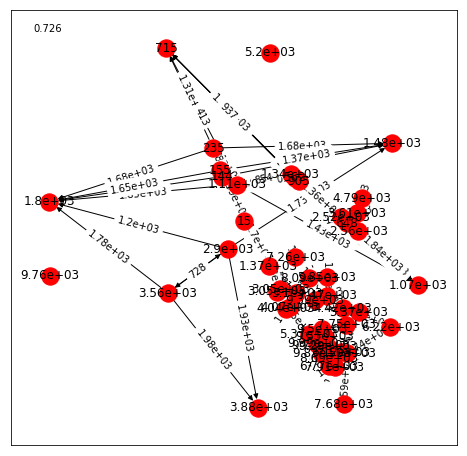

In [7]:
# 计算函数主要是计算：根据策略计算动作PI_t->S_t；根据动作计算新的状态A_t->S_t+1;根据经验计算新策略
#  PI_t->PI_t+1;根据新状态计算回报值S_t+1->R_t+1
GLOBAL_SIZE = 5
NODE_SIZE = 5
EDGE_SIZE = 5

# 根据顶点状态矩阵 nodes　计算边的属性矩阵　edges
# 要返回：edges,senders,receivers
def get_edges_from_nodes_fun(nodes):
    ListTmp = get_neighboursArray_from_nodes(nodes)
    arrayRelTmp1 = ListTmp[0]  # 邻接关系(0-1)矩阵
    arrayDisTmp2 = ListTmp[1]  # 邻接关系矩阵下的距离矩阵
    
    print("arrayRelTmp1",arrayRelTmp1)
    print("arrayDisTmp2",arrayDisTmp2)
    # 计算返回边属性数组: edges
    # 边的条数计算,是[0-1]邻接矩阵所有元素和减去顶点个数ALPHA_AGENTS_NUM
    num_edges = int(int(np.sum(arrayRelTmp1)) - ALPHA_AGENTS_NUM)
    # 知道了边的条数之后，将边的初始属性全部赋值为0
    # 距离属性放在[0]位置,[1],[2]位置放置sender_node和receiver_node的编号
    
    # 根据邻接关系矩阵下的距离矩阵计算当前边的属性
    # 用邻接矩阵来进行边矩阵计算
    edges = []
    for i in range(ALPHA_AGENTS_NUM):
        for j in range(ALPHA_AGENTS_NUM):
            tmpList1 = [0,0,0,0,0]
            if arrayRelTmp1[i][j] == 1:
                tmpList1[0] = arrayDisTmp2[i][j]
                tmpList1[1] = i
                tmpList1[2] = j
                edges.append(tmpList1)


    print("edges_0",edges)
    senders = np.zeros((num_edges))
    receivers = np.zeros((num_edges))
    for i in range(num_edges):
        senders[i] = edges[i][1]   
        receivers[i] = edges[i][2] 
    print("***************",num_edges,len(edges))
            
    return [edges, senders, receivers]
    
# 从　nodes矩阵计算edges
# nodes 的属性是np.array数组,([50,5])
def get_neighboursArray_from_nodes(nodes):
    # 每一个顶点都是sender,
    # 每一个顶点UUV的邻居都作为receivers
    # senders,receivers可用邻接矩阵来计算
    neighboursArray = np.zeros((ALPHA_AGENTS_NUM,ALPHA_AGENTS_NUM))  # 邻接矩阵receiversArray[50][50]
    neighboursDisArray = np.zeros((ALPHA_AGENTS_NUM,ALPHA_AGENTS_NUM))
    
    print("neighboursArray",neighboursArray)
    print("neighboursDisArray",neighboursDisArray)
    for i in range(ALPHA_AGENTS_NUM):
        for j in range(ALPHA_AGENTS_NUM):
            neighbourDis = np.sqrt(np.square(nodes[i][0] - nodes[j][0]) + 
                                   np.square(nodes[i][1] - nodes[j][1]))
            deltaDis = neighbourDis - 2000  
            neighboursDisArray[i][j] = neighbourDis
            # 如果邻居在探测范围之内则建立通讯连接
            if deltaDis < 0:
                neighboursArray[i][j] = 1
                
    return [neighboursArray, neighboursDisArray]  # 返回邻接关系矩阵和当前邻接关系下的实时位置关系矩阵(距离)
    

"""先生成无参数的顶点图，图的顶点个数为：ALPHA_AGENTS_NUM = 50"""
def get_graph_data_dict_0():
    nodes = alphaAgentsInitialPos
    tmpList = get_edges_from_nodes_fun(nodes)
    return {
      "globals": np.random.rand(GLOBAL_SIZE),
      "nodes": nodes,
      "edges": tmpList[0],
      "senders": tmpList[1],
      "receivers": tmpList[2],
    }

graph_dicts = [get_graph_data_dict_0()]
print(graph_dicts)
    

def plot_graphs_tuple_np(graphs_tuple):
    networkx_graphs = utils_np.graphs_tuple_to_networkxs(graphs_tuple)
    num_graphs = len(networkx_graphs)
    _, axes = plt.subplots(1, num_graphs, figsize=(8*num_graphs, 8))
    if num_graphs == 1:
        axes = axes,
    for graph, ax in zip(networkx_graphs, axes):
        plot_graph_networkx(graph, ax)


def plot_graph_networkx(graph, ax, pos=None):
    node_labels = {node: "{:.3g}".format(data["features"][0])
                 for node, data in graph.nodes(data=True)
                 if data["features"] is not None}
    edge_labels = {(sender, receiver): "{:.3g}".format(data["features"][0])
                 for sender, receiver, data in graph.edges(data=True)
                 if data["features"] is not None}
    global_label = ("{:.3g}".format(graph.graph["features"][0])
                  if graph.graph["features"] is not None else None)

    if pos is None:
        pos = nx.spring_layout(graph)
    nx.draw_networkx(graph, pos, ax=ax, labels=node_labels)

    if edge_labels:
        nx.draw_networkx_edge_labels(graph, pos, edge_labels, ax=ax)

    if global_label:
        plt.text(0.05, 0.95, global_label, transform=ax.transAxes)#参数信息：plt.text(x,y,s,family,fontsize,style,color)说明
                                                                #x,y代表注释内容位置，s代表注释文本内容，family设置字体，自带的可选项有{'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}，fontsize字体大小，style设置字体样式，可选项{'normal', 'italic'(斜体), 'oblique'(也是斜体)}



    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    return pos


def plot_compare_graphs(graphs_tuples, labels):
    pos = None
    num_graphs = len(graphs_tuples)
    _, axes = plt.subplots(1,num_graphs, figsize=(5*num_graphs,5))
    if num_graphs == 1:
        axes = axes,
    pos = None
    for name, graphs_tuple, ax in zip(labels, graphs_tuples, axes):
        graph = utils_np.graphs_tuple_to_networkxs(graphs_tuple)[0]
        pos = plot_graph_networkx(graph, ax, pos=pos)
        ax.set_title(name)


tf.reset_default_graph()
graphs_tuple_tf = utils_tf.data_dicts_to_graphs_tuple(graph_dicts)

with tf.Session() as sess:
    graphs_tuple_np = sess.run(graphs_tuple_tf)
    exps_saved_Fun(boolStamp=True,timeStamp=0,dataArray=graphs_tuple_np.edges,fileName="graphs_tuple_np")
    

plot_graphs_tuple_np(graphs_tuple_np)  # 现在知道了S_0


In [11]:
# *******************************************************************************#
"""计算回报矩阵"""
# 目标终止状态是每条边的边长为FLOCKING_DISTANCE=300m,即边属性矩阵的edgeState_T=[1..1]
# 且同时，邻接矩阵(ALPHA_AGENT_NUM,ALPHA_AGENTS_NUM)维度的neighborRelation=[1....1]为单位矩阵
# 由graphs_tuple_np.nodes可以计算出邻接矩阵

edgeRewardHistory = []  # 初始设定回报经验是一个空列表
edgeReward_i = []  # 第i条边的回报经验也是一个空列表
edgeReward_i_t = []  # 第i条边第t时刻的回报是个确定的数值[i,t,edgeReward_i_t]
# 计算第i条边第t时刻的回报值，edgeReward_i_t = (edgeState_t_i-FLOCKING_DISTANCE)
# 计算第i条边第(t+1)时刻的回报值,edgeReward_i_tplus = (edgeState_i_t*edgePolicy_i_t - FLOCKING_DISTANCE)
def get_edge_reward_i_t(i,t,edgeState_t):
    tmp1 = edgeState_t  # 第t时刻的边属性矩阵    
    edgeReward_i_t.append(i)
    edgeReward_i_t.append(t)
    edgeRewardValue_i_t = ((tmp1[-1] - FLOCKING_DISTANCE)/FLOCKING_DISTANCE)
    edgeReward_i_t.append(edgeRewardValue_i_t) 
    return edgeReward_i_t

def get_edge_reward_i(edgeReward_i_t):
    edgeReward_i.append(edgeReward_i_t)
    return edgeReward_i
# 将所有(0,T)的回报全部记录下来
def get_edge_reward_history(edgeRewardHistory, edgeReward_i):
    edgeRewardHistory.append(edgeReward_i)  # 将每条边的回报按照时间序列，存进策略回报经验中去
    return edgeRewardHistory
#***********************************************************************************#    

#***********************************************************************************#
""" 计算策略矩阵 """
# 当前具有给定一个前ｋ步的策略矩阵，当前初始属性
# 策略矩阵是基于当前状态S_t和策略经验来进行综合计算得到的
# state_t是gn在t时刻得到的计算图的属性：graphs_tuple_np.edges，是一个(n,5)的矩阵
GAMA = 0.9  # GAMA是策略经验学习的衰减系数
policyHistory = [] # 初始设定策略经验是一个空列表,
edgePolicy_i = []  # 第i条边的策略经验也是一个空列表
edgePolicy_i_t = []  # 第i条边第t时刻的策略是个确定的数值[i,t,edgePolicy_i_t_value]

# 计算第i条边第t时刻的策略是个确定的数值
def get_edge_policy_i_t(i, time_t, edgeState_i, edgeReward_i):
    tmp1 = edgeState_i
    tmp2 = edgeReward_i
    num_t = len[edgeReward_i]
    t = time_t
    if num_t > 5:
        edgePolicy_i_t_value = ((tmp2[-1]*GAMA)+(pow(GAMA,2)*tmp2[-2])+
                       (pow(GAMA,2)*tmp2[-3])+ (pow(GAMA,3)*tmp2[-4])+
                       (pow(GAMA,4)*tmp2[-5])) # 学习当前时刻前及此时刻前10次的回报经验作为t+1时刻策略的经验约束
    else:
         edgePolicy_i_t_value =  (tmp2[-1]*GAMA)
            
    # 回报函数梯度计算(state_t+1 - state_t)
    def get_delta_reward(edgePolicy_i_t_value,edgeState_i):
        delta_reward_i_t = (get_edge_state_tplus(edgePolicy_i_t_value,edgeState_i[-1])
                        -edgeState_t[-1])
        return delta_reward_i_t
    
    edgePolicy_i_t_value = (get_delta_reward(edgePolicy_i_t_value,tmp1[-1])
                            * edgePolicy_i_t_value)  
    edgePolicy_i_t.append(i)   
    edgePolicy_i_t.append(t)
    edgePolicy_i_t.append(edgePolicy_i_t_value)
    return edgePolicy_i_t  # 由(edgeState_t[], edgeReward_t[])计算得到了edgePolicy_i_t[]



# 根据计算得到的第i条边第t时刻的策略的数值，生成edgePolicy_i[]列表和policyHistory[]二维数组
def get_edge_policy_i(edgePolicy_i,edgePolicy_i_t):
    edgePolicy_i.append(edgePolicy_i_t)
    return edgePolicy_i

def get_policy_history(policyHistory,edgePolicy_i):
    policyHistory.append(edge_policy_i_t)  # 是(num_edges,t+1)二维矩阵    
    return policyHistory
#***********************************************************************************#

"""计算边的Action???"""
# 构建一个函数，来计算由状态state_t|policy_t-->state_t+1
def get_edge_state_tplus(edgePolicy_i_t_value,edgeState_i_t):
    edgeState_i_tplus = edgeState_i_t + edgePolicy_i_t_value
    return edgeState_i_tplus


"""(0,T)内，每一步迭代t,从边属性状态edgeState_t-->(edgePolicy_t-->edgeAction)-->edgeState_tplus
# 的下一状态．但是到达新状态之后，由于集群的各个UUV个体进行状态更新，所以重新构建了边属性状态矩阵．
# 在这个tf.Session迭代过程中，边属性矩阵的改变，改变了邻接矩阵，改变了下一次迭代的edgeState_t+1
# 从edgeState_tplus-->edgeState_t+1状态，从而继续进行迭代，这里需要用到graph_nets基于tensorflow
# 的内部库函数来进行顶点属性的更新．
"""
# 首先从graphs_tuple_np得到edgeState_t--继而迭代得到-->edgeState_tplus
def from_graphs_tuple_get_edgeState_tplus(graphs_tuple_np, time_t):
    # 要得到edgeState_t，首先从graphs_tuple_np中取出当前t时刻的边属性矩阵graphs_tuple_np.edges
    # 每一条边的属性表示为[971.272361389945, 0, 3, 0, 0]，包含了属性，发出顶点，接收顶点，其
    # [发出－接收]顶点对唯一表示了整个迭代过程的边对象的唯一编号
    edgeState_t = graphs_tuple_np.edges   #[num_edge,5]的矩阵
    num_t = len(edgeState_t)
    edgeState_tplus = edgeState_t
    t = time_t
    
    # 在当前时刻根据每条边的策略及策略经验更新计算得到edgeState_tplus
    # 首先循环是在edgeState_t长度num_t内
    # 根据当前状态计算当前边属性的回报矩阵，根据当前状态计算策略矩阵 
    for i in range(num_t):
        edgeCode = edgeState_t[i][1]*1000000 + edgeState_t[i][1]*100 # 边属性的唯一编号对用来表示
    
        # 根据当前状态计算当前边属性的回报矩阵
        edgeReward_i_t = get_edge_reward_i_t(edgeCode,t,edgeState_t)
        
        edgeReward_i = get_edge_reward_i(edgeReward_i_t)
        
        edgeRewardHistory = get_edge_reward_history(edgeReward_i)
        
        # 根据当前状态计算策略矩阵
        edgePolicy_i_t = get_edge_policy_i_t(edgeCode,t,edgeState_i,edgeReward_i)
        
        edgePolicy_i = get_edge_policy_i(edgePolicy_i_t)
        
        policyHistory = get_policy_history(edgePolicy_i)
        
        # 根据当前状态和当前时刻策略，得到该条边下一时刻
        edgeState_tplus[i][0] = get_edge_state_tplus(edgePolicy_i_t_value,edgeState_t[i][0])
        
    return [edgeState_tplus, edgeRewardHistory, policyHistory]
        
        
"""　
*********************************************************************************
    得到了edgeState_tplus之后用graph_nets库函数内部Tensors激励函数，来进行更新．
用将接收边属性聚合到接收点属性class blocks.ReceivedEdgesToNodesAggregator；
将发出边属性聚合到发出顶点属性class blocks.SentEdgesToNodesAggregator函数来进行状态更新．
*********************************************************************************
"""

graphs_tuple = utils_tf.data_dicts_to_graphs_tuple([data_dict_0])







In [7]:
# file save test
q = [1,2,3,4]
c = "alpha{}".format(q[1])
g = [100,200]
#np.savetxt("{}{}.txt".format(c,"good"), g)
#np.loadtxt("{}.txt".format(c))

l=[1,25,31,4,5]
k = l[1]*1000000 + l[2]*100
print(k)

25003100
